In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

In [5]:
%run setup_notebooks.py

In [6]:
from src import setup

In [7]:
import logging
logging.getLogger().setLevel(logging.INFO)

# Labels

In [10]:
path, _ = setup.get_data_paths()
path_labels = path.joinpath('CFD/labels')

2022-04-24 10:28:33,263 [setup] [INFO] get_data_path(): using user-defined data path


In [11]:
[
    e.name for e in path_labels.iterdir()
]

['Cases_highrisk_noMI.xlsx',
 'FC_AI_cases_discrepant.xlsx',
 'list of FC.xlsx',
 'Matching.xlsx',
 'WSSdescriptors_AvgValues.xlsx']

In [12]:
df_labels = pd.read_excel(path_labels.joinpath('WSSdescriptors_AvgValues.xlsx'), engine='openpyxl')
df_labels

,Code,TAWSS,OSI,RRT,transWSS,CFI,TAWSSax,TAWSSsc,WSSratio,TSVI,FC
0,CHUV01_LAD,3.64717,0.014050,0.846456,0.073336,0.057265,3.58750,0.158997,0.176172,228.3910,0
1,CHUV01_LCX,2.55975,0.003294,0.611145,0.055230,0.040732,2.48901,0.337315,0.290763,86.0399,1
2,CHUV02_LAD,2.63011,0.005814,0.582346,0.056851,0.040757,2.59072,0.225770,0.202236,60.5216,1
3,CHUV02_LCX,2.98097,0.000154,0.373309,0.039946,0.014991,2.95874,0.257049,0.077637,22.2836,0
4,CHUV02_RCA,2.43675,0.006072,0.583699,0.098474,0.056273,2.29555,0.589120,0.467824,60.5002,0
...,...,...,...,...,...,...,...,...,...,...,...
183,OLV048_LCX,2.53027,0.000036,0.407267,0.017071,0.007672,2.52312,0.127840,0.048128,10.4213,0
184,OLV049_LAD,2.86934,0.010788,0.673836,0.028470,0.035946,2.84023,0.160913,0.326003,102.0050,1
185,OLV049_RCA,2.09383,0.001343,0.756832,0.034190,0.030094,2.02367,0.213538,0.165229,39.1061,0
186,OLV050_LCX,2.82282,0.000498,0.409097,0.058604,0.025448,2.76545,0.386589,0.137708,33.7438,1


In [13]:
df_labels.isna().any(axis=None)

False

In [14]:
df_labels.Code.is_unique

True

In [15]:
df_labels.FC.value_counts()

0    108
1     80
Name: FC, dtype: int64

In [16]:
df_labels['artery_type'] = df_labels.Code.apply(lambda e: e.split('_')[-1])
df_labels['patient_id'] = df_labels.Code.apply(lambda e: e.split('_')[0])
df_labels.head()

,Code,TAWSS,OSI,RRT,transWSS,CFI,TAWSSax,TAWSSsc,WSSratio,TSVI,FC,artery_type,patient_id
0,CHUV01_LAD,3.64717,0.014050,0.846456,0.073336,0.057265,3.58750,0.158997,0.176172,228.3910,0,LAD,CHUV01
1,CHUV01_LCX,2.55975,0.003294,0.611145,0.055230,0.040732,2.48901,0.337315,0.290763,86.0399,1,LCX,CHUV01
2,CHUV02_LAD,2.63011,0.005814,0.582346,0.056851,0.040757,2.59072,0.225770,0.202236,60.5216,1,LAD,CHUV02
3,CHUV02_LCX,2.98097,0.000154,0.373309,0.039946,0.014991,2.95874,0.257049,0.077637,22.2836,0,LCX,CHUV02
4,CHUV02_RCA,2.43675,0.006072,0.583699,0.098474,0.056273,2.29555,0.589120,0.467824,60.5002,0,RCA,CHUV02


In [17]:
# Is there exactly one culprit segment for each patient ?
(df_labels.groupby('patient_id').FC.sum() == 1).all()

True

In [18]:
df_labels.groupby('artery_type').FC.mean()

artery_type
LAD    0.521739
LCX    0.343284
RCA    0.403846
Name: FC, dtype: float64

Generate a table summarizing samples & labels:

In [19]:
s = df_labels.groupby('artery_type').FC.value_counts()
s = s.sort_index()

In [20]:
f = s.rename('counts').to_frame().reset_index()
f = f.pivot('artery_type', 'FC', 'counts')
f['total'] = f.sum(axis=1)
f = f.append(f.sum(axis=0).rename('total'))
f.T

artery_type,LAD,LCX,RCA,total
FC,,,,
0,33,44,31,108
1,36,23,21,80
total,69,67,52,188


In [21]:
print(f.T.to_latex())

\begin{tabular}{lrrrr}
\toprule
artery\_type &  LAD &  LCX &  RCA &  total \\
FC    &      &      &      &        \\
\midrule
0     &   33 &   44 &   31 &    108 \\
1     &   36 &   23 &   21 &     80 \\
total &   69 &   67 &   52 &    188 \\
\bottomrule
\end{tabular}



## Naive classifiers

In [22]:
from sklearn.metrics import classification_report

In [23]:
# Naive 1: predict constant, the dominant class
y = df_labels.FC.values
yhat = np.ones(y.shape) * df_labels.FC.mode()[0]

print(classification_report(y, yhat, zero_division=0))
naive1 = classification_report(y, yhat, zero_division=0, output_dict=True)

              precision    recall  f1-score   support

           0       0.57      1.00      0.73       108
           1       0.00      0.00      0.00        80

    accuracy                           0.57       188
   macro avg       0.29      0.50      0.36       188
weighted avg       0.33      0.57      0.42       188



In [24]:
# Naive 2: predict 1 always
y = df_labels.FC.values
yhat = np.ones(y.shape)

print(classification_report(y, yhat, zero_division=0))
naive2 = classification_report(y, yhat, zero_division=0, output_dict=True)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       108
           1       0.43      1.00      0.60        80

    accuracy                           0.43       188
   macro avg       0.21      0.50      0.30       188
weighted avg       0.18      0.43      0.25       188



In [25]:
df_labels.groupby('artery_type').FC.value_counts()

artery_type  FC
LAD          1     36
             0     33
LCX          0     44
             1     23
RCA          0     31
             1     21
Name: FC, dtype: int64

In [26]:
mapping = dict(df_labels.groupby('artery_type').FC.agg(pd.Series.mode))
mapping

{'LAD': 1, 'LCX': 0, 'RCA': 0}

In [27]:
# Naive 3: predict dominant class based on artery
yhat = df_labels.artery_type.map(mapping)
print(classification_report(y, yhat))

naive3 = classification_report(y, yhat, zero_division=0, output_dict=True)

              precision    recall  f1-score   support

           0       0.63      0.69      0.66       108
           1       0.52      0.45      0.48        80

    accuracy                           0.59       188
   macro avg       0.58      0.57      0.57       188
weighted avg       0.58      0.59      0.59       188



In [28]:
def process_report(r):
    f1mean = 2 * r['1']['f1-score'] * r['0']['f1-score'] / (r['1']['f1-score'] + r['0']['f1-score'])
    out = {'f1-mean': f1mean, 'accuracy': r['accuracy']}
    for n in ('0', '1'):
        sub = r[n]
        for k, v in sub.items():
            if k == 'support':
                continue
            out[f'{n}.{k}'] = v
            
    return out

In [29]:
baseline = {
    'const_0': process_report(naive1), 
    'const_1': process_report(naive2), 
    'const_artery': process_report(naive3)
}
baseline = pd.DataFrame(baseline)
baseline.T

,f1-mean,accuracy,0.precision,0.recall,0.f1-score,1.precision,1.recall,1.f1-score
const_0,0.000000,0.574468,0.574468,1.000000,0.729730,0.000000,0.00,0.000000
const_1,0.000000,0.425532,0.000000,0.000000,0.000000,0.425532,1.00,0.597015
const_artery,0.558226,0.590426,0.630252,0.694444,0.660793,0.521739,0.45,0.483221


In [71]:
print(baseline.T.to_latex(float_format="{:0.2f}".format))

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  f1-mean &  accuracy &  0.precision &  0.recall &  0.f1-score &  1.precision &  1.recall &  1.f1-score \\
\midrule
const\_1      &     0.00 &      0.57 &         0.57 &      1.00 &        0.73 &         0.00 &      0.00 &        0.00 \\
const\_0      &     0.00 &      0.43 &         0.00 &      0.00 &        0.00 &         0.43 &      1.00 &        0.60 \\
const\_artery &     0.56 &      0.59 &         0.63 &      0.69 &        0.66 &         0.52 &      0.45 &        0.48 \\
\bottomrule
\end{tabular}



In [ ]:
naive

In [64]:
pd.DataFrame(naive1)

,0,1,accuracy,macro avg,weighted avg
precision,0.574468,0.0,0.574468,0.287234,0.330014
recall,1.000000,0.0,0.574468,0.500000,0.574468
f1-score,0.729730,0.0,0.574468,0.364865,0.419206
support,108.000000,80.0,0.574468,188.000000,188.000000


## Patients statistics

In [22]:
df_labels['patient'] = df_labels.Code.apply(lambda s: s.split('_')[0])

In [23]:
df_labels.patient.nunique()

80

In [24]:
df_labels.groupby('patient').count()['Code'].rename('n_record_per_patient').value_counts()

2    52
3    28
Name: n_record_per_patient, dtype: int64

# Data

In [32]:
path_data = path.joinpath('CFD/ClinicalCFD')
path_magnitude = path_data.joinpath('MagnitudeClinical/')
path_vector = path_data.joinpath('VectorClinical/')

In [33]:
files_magnitude = list(map(lambda e: e.name, path_magnitude.glob('*.vtp')))
files_vector = list(map(lambda e: e.name, path_vector.glob('*.vtp')))

In [34]:
len(files_magnitude), len(files_vector)

(188, 188)

In [35]:
files_vector[:3], files_magnitude[:3]

(['FRH005_LCX_WSS.vtp', 'FRH012_RCA_WSS.vtp', 'OLV009_LAD_WSS.vtp'],
 ['OLV015_LAD_WSSMag.vtp', 'CHUV08_LCX_WSSMag.vtp', 'OLV047_LCX_WSSMag.vtp'])

In [36]:
# Compare patients between the two sets
extract_name_vessel = lambda name: '_'.join(name.split('_')[:-1])

patients_vector = list(map(extract_name_vessel, files_vector))
patients_magnitude = list(map(extract_name_vessel, files_magnitude))
len(set(patients_magnitude)), len(set(patients_vector))

(188, 188)

In [37]:
len(set(patients_vector).intersection(patients_magnitude))

188

# WSS Values

In [5]:
import torch

## Single data point (i.e., graph)

In [216]:
path = setup.get_local_data_path()
sample_wss = path.joinpath('sample_wss.pt')
data = torch.load(sample_wss)
data

Data(x=[3547, 30], edge_index=[2, 21178], y=0, coord=[3547, 3], g_x=[3])

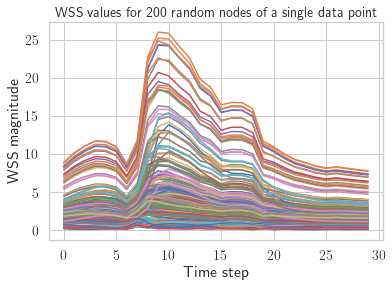

In [217]:
ids = torch.randperm(data.x.shape[0])
take_n = 200
plt.plot(data.x[ids[:take_n]].T)
plt.xlabel('Time step')
plt.ylabel('WSS magnitude')
plt.title(f'WSS values for {take_n} random nodes of a single data point');

## Compare several data points

In [218]:
path = setup.get_dataset_path('WssToCnc_KNN5')
files = list(file for file in path.glob('*.pt') if 'KNN5' not in file.name)
len(files)

2022-03-20 16:01:46,231 [setup] [INFO] get_data_path(): using user-defined data path


188

In [219]:
data = {
    fpath.name: torch.load(fpath) for fpath in files
}
len(data)

188

## Statistics for WSS values

### Maximum WSS values across all nodes



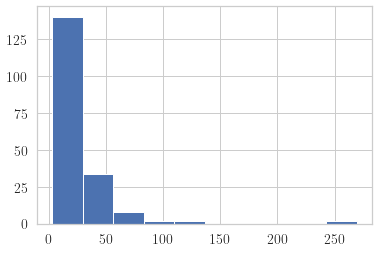

In [220]:
max_wss = [sample.x.max().item() for sample in data.values()]
plt.hist(max_wss);

### Statistics of WSS values across all nodes



In [221]:
df = [
    {
        'fname': fname,
        'y': sample.y,
        'max': sample.x.max().item(),
        'min': sample.x.min().item(),
        'mean': sample.x.mean().item(),
        'median': sample.x.median().item()
    }
    for fname, sample in data.items()
]
df = pd.DataFrame(df)
df

,fname,y,max,min,mean,median
0,CHUV01_LAD.pt,0,14.240928,0.052125,2.539214,2.184747
1,CHUV01_LCX.pt,1,38.117691,0.035272,3.524113,2.641639
2,CHUV02_LAD.pt,1,16.567072,0.038439,2.129455,1.790440
3,CHUV02_LCX.pt,0,9.141841,0.249737,2.199678,1.844735
4,CHUV02_RCA.pt,0,9.979980,0.018594,1.972398,1.658392
...,...,...,...,...,...,...
183,OLV048_LCX.pt,0,9.084010,0.052825,1.361105,1.109133
184,OLV049_LAD.pt,1,16.934998,0.021341,3.109328,2.532758
185,OLV049_RCA.pt,0,12.819361,0.040273,1.739379,1.094731
186,OLV050_LCX.pt,1,14.567917,0.175114,2.578892,2.273204


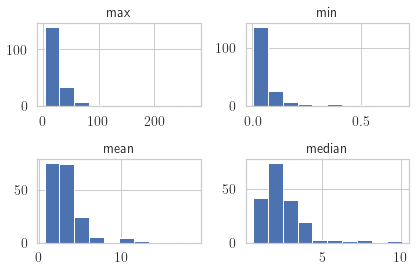

In [222]:
df.drop(columns='y').hist()
plt.tight_layout()

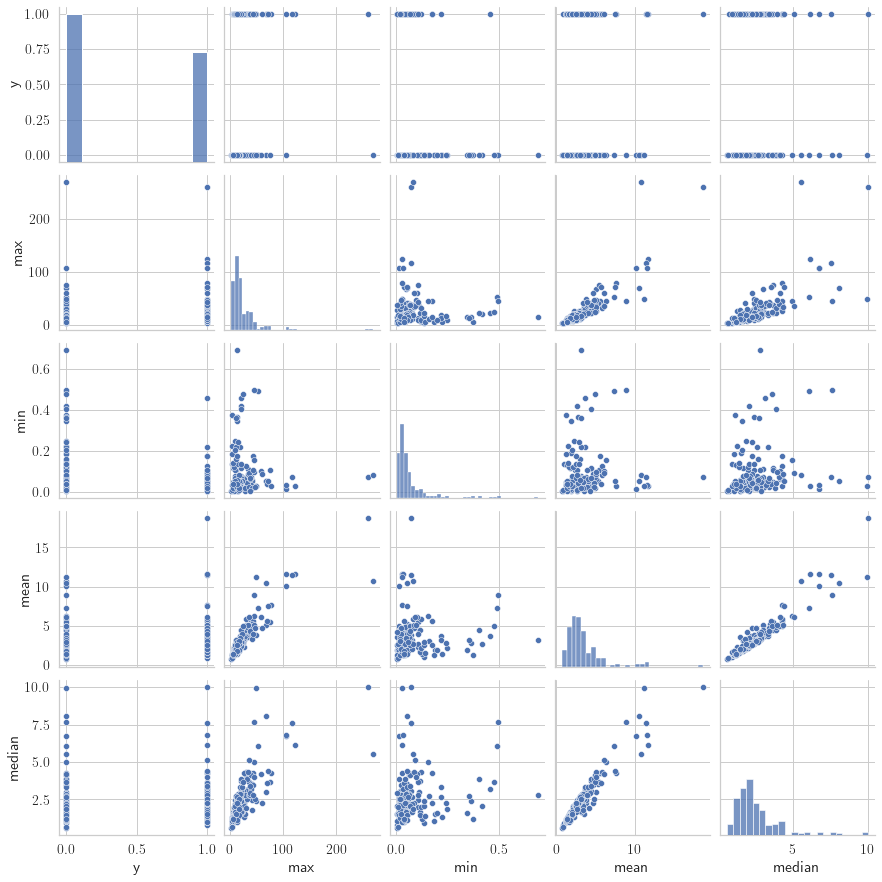

In [223]:
sns.pairplot(df);

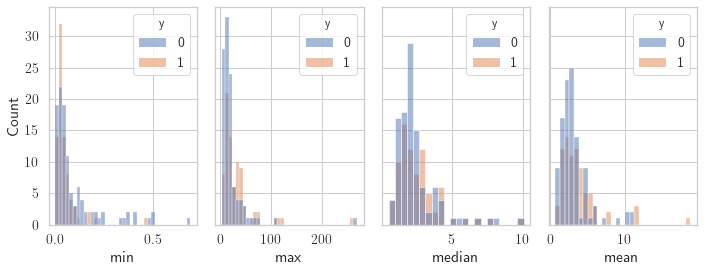

In [224]:
_, ax = plt.subplots(1, 4, figsize=(10, 4), sharey=True)

for col, a in zip(['min', 'max', 'median', 'mean'], ax):
    sns.histplot(data=df, x=col, hue='y', ax=a)
    
plt.tight_layout()

### Get outliers

In [225]:
df_outliers = df[(df['max'] > 200)]
outliers = df_outliers.fname.tolist()
df_outliers

,fname,y,max,min,mean,median
5,CHUV03_LAD.pt,1,260.971252,0.073499,18.685675,10.034504
42,OLV036_LAD.pt,0,269.395020,0.084717,10.732800,5.544541


In [226]:
outliers

['CHUV03_LAD.pt', 'OLV036_LAD.pt']

## Visualize subsampled data

In [233]:
n_samples = 30

# Sample data points without outliers
subset = df.fname[~df.fname.isin(outliers)]
subset = subset.sample(n=n_samples).tolist()

# Get corresponding data
subset = {fname: data[fname] for fname in subset}
subset

{'OLV030_RCA.pt': Data(x=[5674, 30], edge_index=[2, 33932], y=0, coord=[5674, 3], g_x=[1, 3]),
 'OLV047_LCX.pt': Data(x=[6416, 30], edge_index=[2, 38392], y=1, coord=[6416, 3], g_x=[1, 3]),
 'OLV045_LAD.pt': Data(x=[5626, 30], edge_index=[2, 33652], y=0, coord=[5626, 3], g_x=[1, 3]),
 'CHUV17_RCA.pt': Data(x=[7687, 30], edge_index=[2, 46012], y=1, coord=[7687, 3], g_x=[1, 3]),
 'CHUV35_LAD.pt': Data(x=[10056, 30], edge_index=[2, 60234], y=0, coord=[10056, 3], g_x=[1, 3]),
 'CHUV05_LCX.pt': Data(x=[7515, 30], edge_index=[2, 44988], y=0, coord=[7515, 3], g_x=[1, 3]),
 'OLV012_RCA.pt': Data(x=[4570, 30], edge_index=[2, 27316], y=0, coord=[4570, 3], g_x=[1, 3]),
 'OLV047_RCA.pt': Data(x=[9024, 30], edge_index=[2, 54040], y=0, coord=[9024, 3], g_x=[1, 3]),
 'CHUV15_LCX.pt': Data(x=[5825, 30], edge_index=[2, 34844], y=1, coord=[5825, 3], g_x=[1, 3]),
 'OLV028_RCA.pt': Data(x=[5302, 30], edge_index=[2, 31706], y=0, coord=[5302, 3], g_x=[1, 3]),
 'OLV022_LCX.pt': Data(x=[6156, 30], edge_index=

In [228]:
def subsample_nodes(data_point, take: int = 200):
    n_nodes = data_point.x.shape[0]
    ids = np.random.choice(n_nodes, take, replace=False)
    return data_point.x[ids, :]

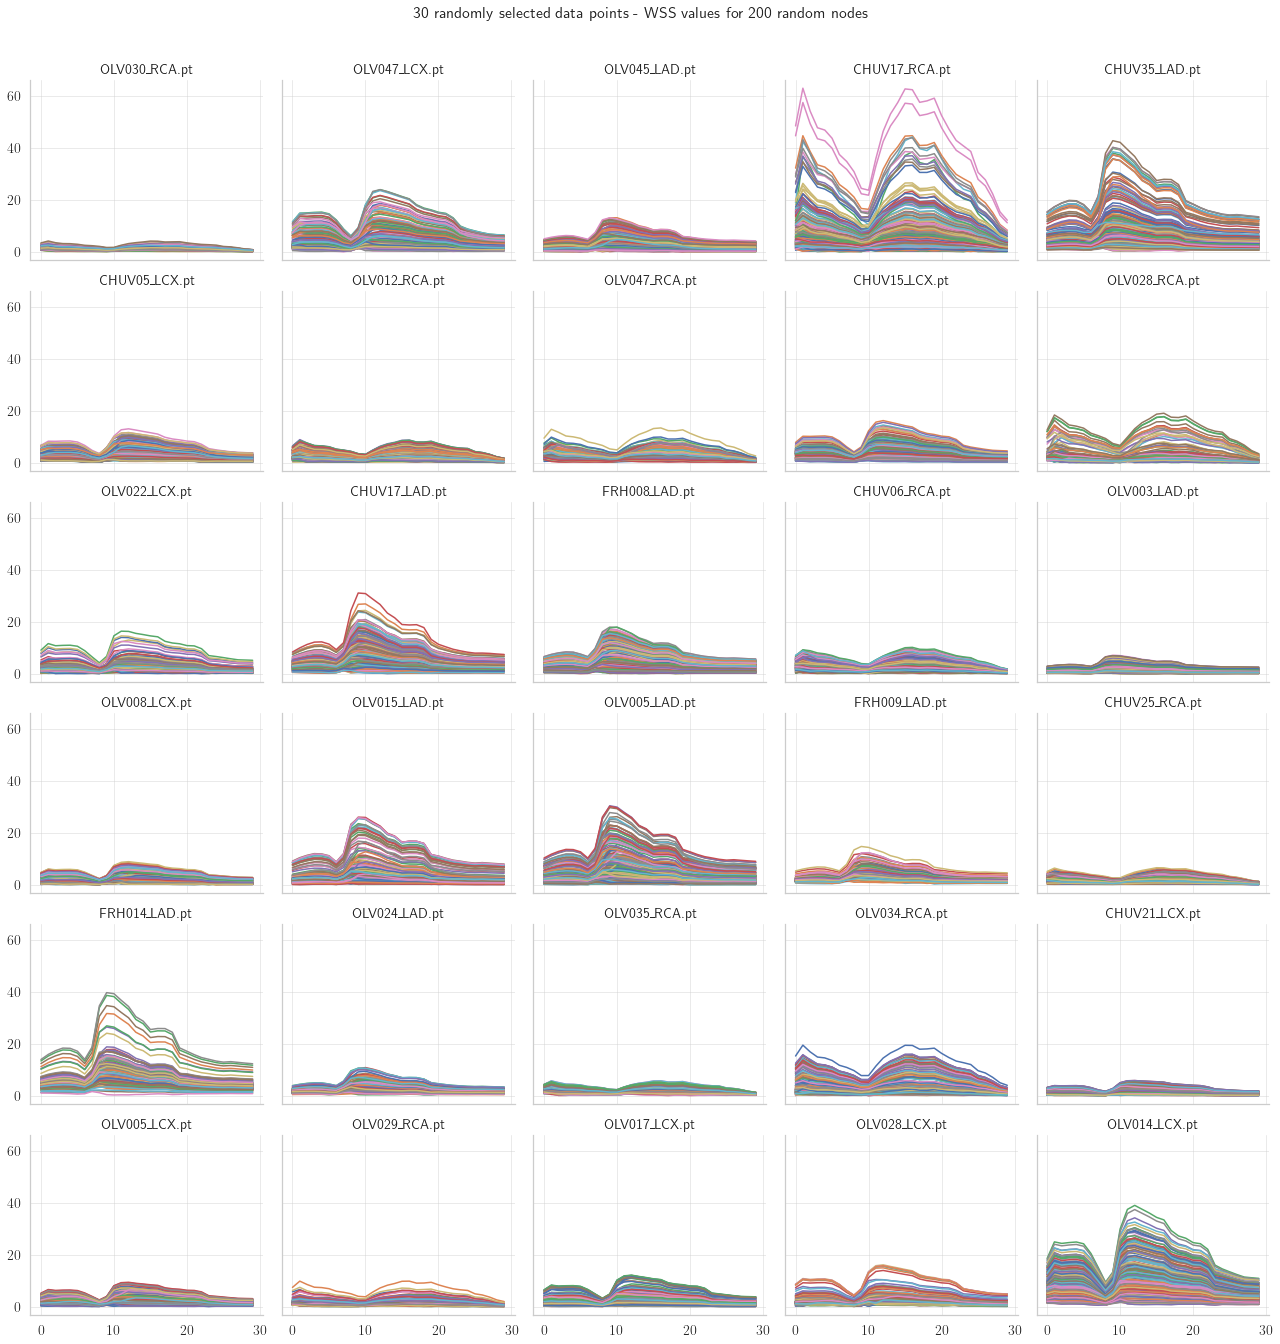

In [234]:
from math import ceil

n_nodes = 200
ncol = 5
nrow = ceil(len(subset) / ncol)
_, ax = plt.subplots(nrow, ncol, figsize=(3.5 * ncol + .5, 3 * nrow + .5), sharex=True, sharey=True)

for (fname, sample), a in zip(subset.items(), ax.ravel()):
    a.set_title(fname)
    data_plot = subsample_nodes(sample, take=n_nodes)
    a.plot(data_plot.T)
    a.grid(alpha=0.4)
    
plt.suptitle(f'{len(subset)} randomly selected data points - WSS values for {n_nodes} random nodes', y=1.01, fontsize=16)
plt.tight_layout()
process_figure('figs/wss_visualization.pdf')

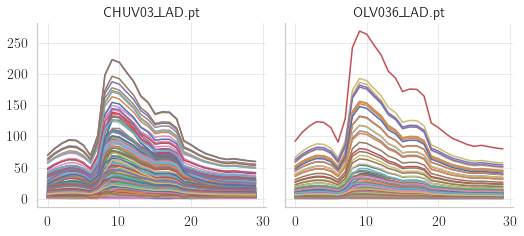

In [235]:
ncol = len(outliers)
nrow = 1
_, ax = plt.subplots(nrow, ncol, figsize=(3.5 * ncol + .5, 3 * nrow + .5), sharex=True, sharey=True)

for outlier, a in zip(outliers, ax.ravel()):
    a.set_title(outlier)
    data_plot = subsample_nodes(data[outlier], take=300)
    a.plot(data_plot.T)
    a.grid(alpha=0.4)
    
    
plt.tight_layout()
process_figure('figs/wss_visualization_outliers.pdf')

# Statistics coordinates

In [274]:
def compute_sample_coord_std(sample):
    # Compute difference between x-y-z coords for all neighbourhing nodes
    return sample.coord[sample.edge_index].diff(dim=0).std()

In [276]:
coord_stds = torch.tensor([
    compute_sample_coord_std(sample) for sample in data.values()
])

In [278]:
coord_stds.mean(), coord_stds.std()

(tensor(0.1833), tensor(0.0368))

In [285]:
e.coord[e.edge_index[:, 0]].diff(dim=0)

tensor([[ 0.0615, -0.2364, -0.0764]])

# Graph properties & KNN5


In [8]:
import torch
from torch_geometric.utils import to_scipy_sparse_matrix

In [11]:
path = setup.get_dataset_path('CoordToCnc_KNN5')

2022-04-05 23:27:16,879 [setup] [INFO] get_data_path(): using user-defined data path


In [69]:
files = list(path.glob('*.pt'))

len(files), [e.name for e in files]

(5,
 ['OLV047_LCX.pt',
  'OLV047_LCX_KNN3.pt',
  'OLV047_LCX_KNN5.pt',
  'OLV047_LCX_NOISE1.pt',
  'OLV047_LCX_old.pt'])

In [72]:
file = files[0]
fileknn3 = files[1]
fileknn5 = files[2]
filenoise = files[3]
fileold = files[4]

In [73]:
data = torch.load(file)
dataknn3 = torch.load(fileknn3)
dataknn5 = torch.load(fileknn5)
datanoise = torch.load(filenoise)
dataold = torch.load(fileold)

data, dataknn3, dataknn5, datanoise, dataold

(Data(x=[6416, 0], edge_index=[2, 38392], y=1, coord=[6416, 3], g_x=[1, 3]),
 Data(x=[6416, 0], edge_index=[2, 25256], y=1, coord=[6416, 3], g_x=[1, 3]),
 Data(x=[6416, 0], edge_index=[2, 35572], y=1, coord=[6416, 3], g_x=[1, 3]),
 Data(x=[6416, 0], edge_index=[2, 38392], y=1, coord=[6416, 3], g_x=[1, 3]),
 Data(x=[6416, 0], edge_index=[2, 38392], y=1, coord=[6416, 3], g_x=[1, 3]))

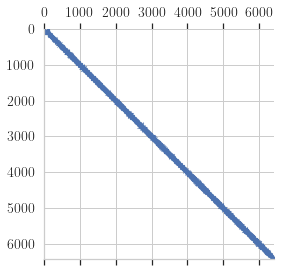

In [118]:
plt.spy(to_scipy_sparse_matrix(data.edge_index), markersize=0.1)
process_figure('figs/adj_mx_sparsity.pdf')

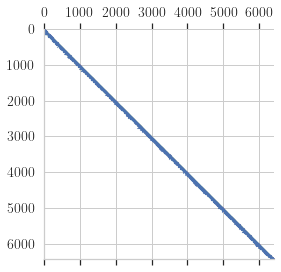

In [17]:
plt.spy(to_scipy_sparse_matrix(dataold.edge_index), markersize=0.1)
process_figure('figs/adj_mx_sparsity_old.pdf')

In [74]:
def plot_neighbours(data, data_knns):
    A = to_scipy_sparse_matrix(data.edge_index)
    n_neig = np.array(A.sum(-1)).squeeze()
    series = pd.Series(n_neig).rename('original')
    
    series = [series]
    for k, data_knn in data_knns.items():
        A_knn = to_scipy_sparse_matrix(data_knn.edge_index)
        n_neig_knn = np.array(A_knn.sum(-1)).squeeze()
        series_knn = pd.Series(n_neig_knn).rename(f'{k}')
        series.append(series_knn)
    
    df = pd.DataFrame(series).T
    df = df.melt(value_name='n_neigh', var_name='data')
    
    return df

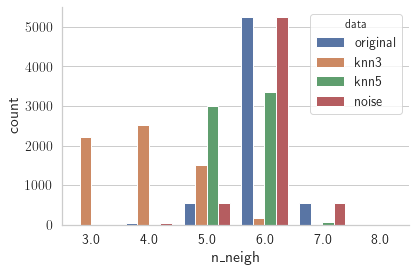

In [76]:
df = plot_neighbours(data, {'knn3': dataknn3, 'knn5': dataknn5, 'noise': datanoise})
sns.countplot(x='n_neigh', data=df, hue='data')
process_figure('figs/knn_neighbours.pdf')

In [26]:
from torch_geometric.utils.convert import to_networkx
from torch_geometric.utils import k_hop_subgraph
import networkx as nx

In [116]:
def plot_subgraph(data, k_hop, central_node, directed: bool = False, transparent: bool = False, ax: bool = None):
    sub_nodes, sub_edge_index, central_node, _ = k_hop_subgraph(central_node, k_hop, data.edge_index)
    
    node_xyz = data.coord[sub_nodes, :].numpy()
    edge_xyz = np.array([
        (data.coord[u].numpy(), data.coord[v].numpy()) for u, v in sub_edge_index.T
    ])
    
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')
    
    # Plot edges
    if directed is False:
        alpha = 0.1 if transparent else 0.3
        for vizedge in edge_xyz:
            ax.plot(*vizedge.T, color='k', alpha=alpha)
    else:
        start_edges = sub_edge_index[1, :]
        
        locX, locY, locZ = data.coord[start_edges].T
        
        end_edges = sub_edge_index[0, :]
        locX2, locY2, locZ2 = data.coord[end_edges].T
        
        dirX, dirY, dirZ = locX2 - locX, locY2 - locY, locZ2 - locZ
        
        alpha = 0.3 if transparent else 0.6
        ax.quiver(locX, locY, locZ, dirX, dirY, dirZ, alpha=alpha)

    # Plot nodes
    color = 'green' if transparent else 'blue'
    ax.scatter3D(*node_xyz.T, s=50, color=color)
    # Plot central node in red
    ax.scatter3D(*node_xyz[central_node].T, color='red', s=100)

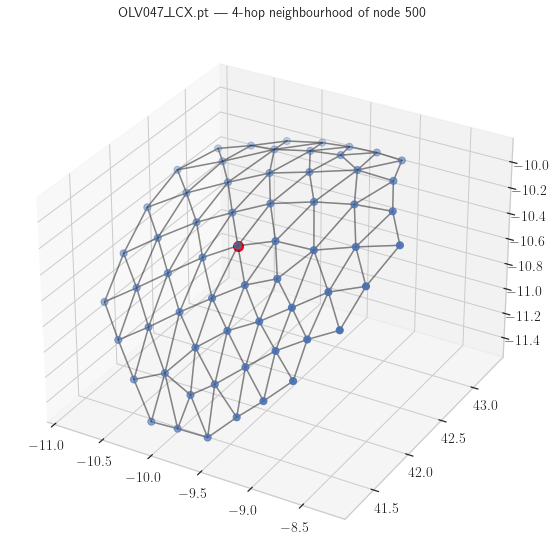

In [86]:
k_hop = 4
central_node = 500

plot_subgraph(data, k_hop=k_hop, central_node=central_node)
plt.title(f'{file.name} --- {k_hop}-hop neighbourhood of node {central_node}')
process_figure('figs/knn_subgraph_original.pdf')

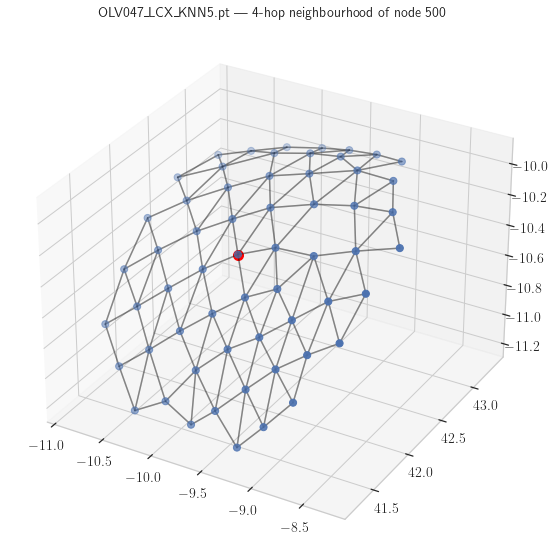

In [29]:
plot_subgraph(dataknn5, k_hop=k_hop, central_node=central_node)
plt.title(f'{fileknn5.name} --- {k_hop}-hop neighbourhood of node {central_node}')
process_figure('figs/knn_subgraph_knn5.pdf')

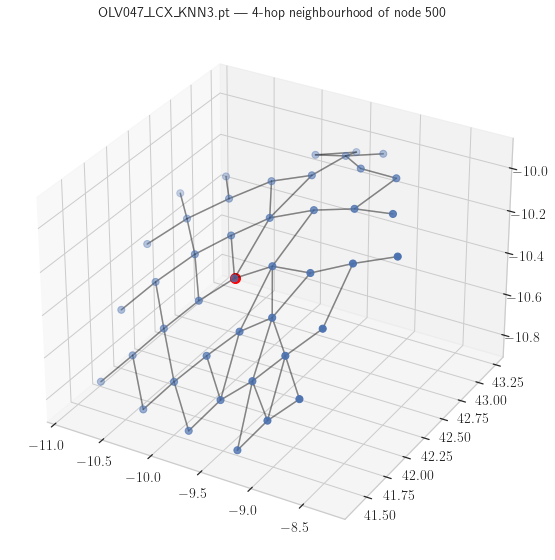

In [60]:
plot_subgraph(dataknn3, k_hop=4, central_node=500)
plt.title(f'{fileknn3.name} --- {k_hop}-hop neighbourhood of node {central_node}')
process_figure('figs/knn_subgraph_knn3.pdf')

In [137]:
datatest = data.clone()
datatest.coord = datatest.coord + torch.randn_like(datatest.coord) * 4e-2

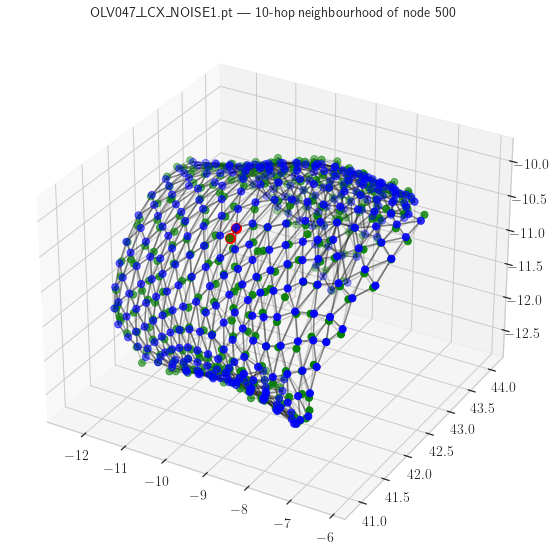

In [138]:
k_hop = 10

plot_subgraph(data, k_hop=k_hop, central_node=500)
plot_subgraph(datatest, k_hop=k_hop, central_node=500, ax=plt.gca(), transparent=True)
plt.title(f'{filenoise.name} --- {k_hop}-hop neighbourhood of node {central_node}')
process_figure('figs/knn_subgraph_knn3.pdf')

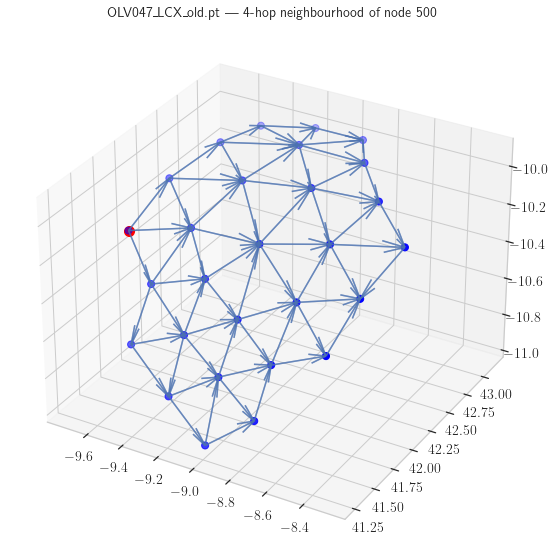

In [136]:
k_hop = 4
plot_subgraph(dataold, k_hop=k_hop, central_node=central_node, directed=True)
plt.title(f'{fileold.name} --- {k_hop}-hop neighbourhood of node {central_node}')
process_figure('figs/knn_subgraph_original_old.pdf')

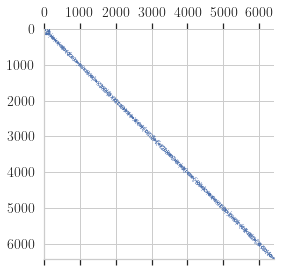

In [166]:
d = to_scipy_sparse_matrix(data.edge_index) - to_scipy_sparse_matrix(dataknn5.edge_index)
plt.spy(d, markersize=0.1)
process_figure('figs/knn_adj_diff_knn5.pdf')

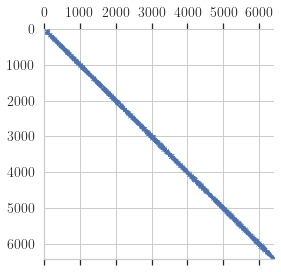

In [153]:
d = to_scipy_sparse_matrix(data.edge_index) - to_scipy_sparse_matrix(dataknn3.edge_index)
plt.spy(d, markersize=0.1)
process_figure('figs/knn_adj_diff_knn3.pdf')